## SciANN - Implementing the PINN model

In [3]:
#Importing libraries for SciANN
import numpy as np
import matplotlib.pyplot as plt 
import sciann as sn

In [20]:
#Model parameters
time = 10
no_of_pixels_considered = 200
start_pixel = 200
no_of_collocations = 100

### Importing the Image

In [6]:
import skimage.io
import skimage.color

image = skimage.io.imread("image-final.jpg")[start_pixel:start_pixel+no_of_pixels_considered, start_pixel:start_pixel+no_of_pixels_considered]/255 #reading the image

im_neew = np.array([image]).repeat(10,2)
im_new = np.zeros((image.shape[0],image.shape[1],10))
for x in range(image.shape[0]):
    for y in range(image.shape[1]):
        for k in range(time):
            im_new[x][y][k] = image[x][y][0]

x_data, y_data, t_data = np.meshgrid(np.linspace(0.0, image.shape[0]-1, image.shape[0]), np.linspace(0.0, image.shape[1]-1, image.shape[1]) , np.linspace(0, time - 1, time))
f_data = im_new

### Setting up the neural network

In [8]:
x = sn.Variable('x')
y = sn.Variable('y')
t = sn.Variable('t')
f = sn.Functional('f', [x, y, t], [10, 30, 30, 10], 'tanh') 
#specifying the layer dimensions as well as the activation function

### Initial state of the predictor

In [9]:
## Initial state of the predictor
f_pred = f.eval([x_data, y_data, t_data]) #evaluating the neural network on the original data

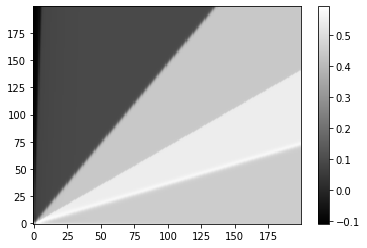

In [10]:
#plotting the initial predicted image
im = plt.pcolor(x_data[:, :, 0], y_data[:,:,0], f_pred[:,:,0], cmap='gray',shading='auto')
plt.colorbar(im)


Image shape is (200, 200, 3) 
End time is 9 s


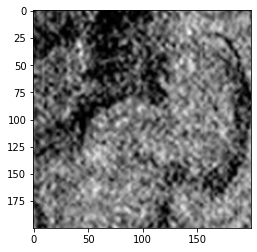

In [21]:
#Displaying the input image
print("Image shape is", image.shape, "\nEnd time is", time-1, "s")

#plotting the initial image
plt.imshow(f_data[:,:,0], cmap='gray')

### Setting up the optimization model and defining the objective function

In [13]:
## defining the loss/objective function
f_x = sn.math.diff(f, x, order=1)
f_y = sn.math.diff(f, y, order=1)
f_t = sn.math.diff(f, t, order=1)

f_xx = sn.math.diff(f, x, order=2)
f_yy = sn.math.diff(f, y, order=2)

mod_deltax = f_x/(1+((f_x*f_x)+(f_y*f_y))/1000)        # funtion g(s), k=1000
mod_deltay = f_y/(1+((f_x*f_x)+(f_y*f_y))/1000) 

# divergence of (g(s). del u)
div = sn.math.diff(mod_deltax, x, order=1)
div = div + sn.math.diff(mod_deltay, y, order = 1) 

# initial loss -> deviation of predicted image at t=0 and actual.
TOL = 0.0001

C1 = 0

# differential equation loss -> equation loss for t>0
L2 = (f_t - div)**2

# boundary loss -> derivative w.r.t x is zero at vertical edges, derivative w.r.t y is zero at horizontal edges.
TOL = 0.0001
C2 = (1 - sn.math.sign(x - (TOL))) * (f_x * f_x) #x = 0
C3 = (1 + sn.math.sign(x - (image.shape[0] - TOL))) * (f_x * f_x) #x = last

C4 = (1 - sn.math.sign(y - (TOL))) * (f_y * f_y) #y = 0
C5 = (1 + sn.math.sign(y - (image.shape[1] - TOL))) * (f_y * f_y) #y = last

Total_loss = C1 + C2 + C3 + C4 + C5 + L2

## defining the model
d1 = sn.Data(f)
d2 = sn.Data(Total_loss)
m = sn.SciModel([x, y, t], [d1, d2])

### Training the model

In [15]:
##training the model using the co-location points and the function
##which is to be approximated (required to calculate the cost function)
h = m.train([x_data, y_data, t_data], [im_new, 'zero'], learning_rate=0.005, epochs=100, verbose=1, batch_size=128)
# h = m.train([x_data, y_data], f_data, learning_rate=0.002, epochs=500, verbose=0)


Total samples: 400000 
Batch size: 128 
Total batches: 3125 

Epoch 1/100
3125/3125 [==============================] - 16s 5ms/step - batch: 1562.0000 - size: 128.0000 - loss: 0.0245 - f_loss: 0.0245 - add_12_loss: 9.3301e-06 - lr: 0.0050 - time: 16.1853
Epoch 2/100
3125/3125 [==============================] - 17s 5ms/step - batch: 1562.0000 - size: 128.0000 - loss: 0.0236 - f_loss: 0.0236 - add_12_loss: 7.0803e-06 - lr: 0.0050 - time: 17.1769
Epoch 3/100
3125/3125 [==============================] - 16s 5ms/step - batch: 1562.0000 - size: 128.0000 - loss: 0.0228 - f_loss: 0.0228 - add_12_loss: 1.2865e-05 - lr: 0.0050 - time: 15.9850
Epoch 4/100
3125/3125 [==============================] - 16s 5ms/step - batch: 1562.0000 - size: 128.0000 - loss: 0.0226 - f_loss: 0.0226 - add_12_loss: 1.4266e-05 - lr: 0.0050 - time: 16.1175
Epoch 5/100
3125/3125 [==============================] - 16s 5ms/step - batch: 1562.0000 - size: 128.0000 - loss: 0.0268 - f_loss: 0.0261 - add_12_loss: 6.4918e-04 -

### Plotting the cost history

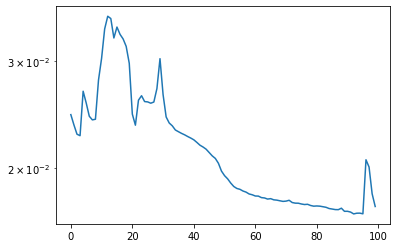

In [16]:
plt.semilogy(h.history['loss']) #plotting the training history

### Testing the Neural Network

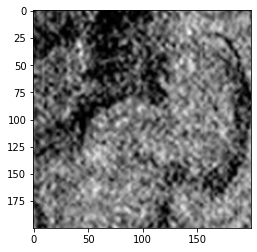

In [17]:
x_test = x_data
y_test = y_data
t_test = t_data

f_pred = f.eval([x_test, y_test, t_test])

plt.imshow(im_new[:, :, 0], cmap='gray')
## the correct output using the original function at time t = 0


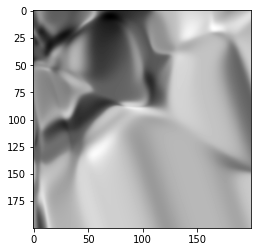

In [18]:
plt.imshow(f_pred[:, :, 0], cmap='gray')
## the predicted output using the neural network at time t = 0.

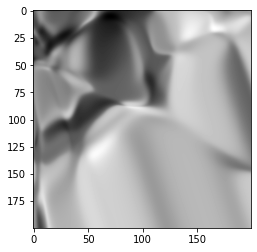

In [19]:
plt.imshow(f_pred[:, :, -1], cmap='gray')
## the predicted output using the neural network at time t = T.

## Finite Difference Method

In [22]:
import numpy as np
import warnings
import matplotlib.pylab as pyp
import math
from PIL import Image

resultImage = np.array(Image.open('image-final.jpg').convert('L'))  ## Specify the original file path

im_min, im_max = resultImage.min(), resultImage.max()

print ("Original image:", resultImage.shape, resultImage.dtype, im_min, im_max)
resultImage = (resultImage - im_min) / (float)(im_max - im_min)   ## Conversion
## Normalization of the input  features

print ("Perona-Malik Anisotropic Diffusion:", resultImage.shape, resultImage.dtype, resultImage.min(), resultImage.max())


FileNotFoundError: [Errno 2] No such file or directory: './download.jpeg'

### Printing the Original image

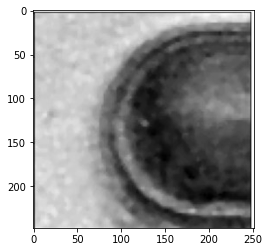

In [67]:
pyp.figure('Image BEFORE Perona-Malik anisotropic diffusion')
pyp.imshow(resultImage, cmap='gray')
pyp.axis('on')


pyp.show() #Display image

### FDM - Main functions

In [68]:
# 	****(Diffusivity)Edge-Stopping Functions*****

def f(grad_u,b):
    return np.exp(-1* (np.power(grad_u,2))/(np.power(b,2)))
##the diffusion coefficient is going to be input as b

def f2(grad_u,b): 
	func = 1/(1 + ((grad_u/b)**2))
	return func

# The main diffusion function which implements the FDM

def anisodiff(im, steps, b, lam = 0.25):  #takes image input, the number of iterations, the hyperparameter 'b' and lambda
    
    
    tolerance=0.001
    im_temp= np.pad(im, [(1,1), (1,1)], mode='constant')
    
    #Add extra boundary with same pixels as th boundary for easier computation of gradients
    im_temp[0,1:-1]=im[0,:]
    im_temp[-1,1:-1]=im[-1,:]
    im_temp[1:-1,0]=im[:,0]
    im_temp[1:-1,-1]=im[:,-1]
    im_new=im

    for t in range(steps): 

        dn = im_temp[:-2,1:-1] - im_temp[1:-1,1:-1] 
        # [a0,a1,a2,a3] - [a1,a2,a3,a4] -- taking finite difference of the consecutive elements
        # backside difference
        # (del(u)/del(x))-

        ds = im_temp[2:,1:-1] - im_temp[1:-1,1:-1]
        # [a2,a3,a4,a5] - [a1,a2,a3,a4] -- taking finite difference of the consecutive elements
        # frontside difference for change in x
        # (del(u)/del(x))+ 

        de = im_temp[1:-1,2:] - im_temp[1:-1,1:-1]
        # [a2,a3,a4,a5] - [a1,a2,a3,a4] -- taking finite difference of the consecutive elements
        # frontside difference for change in y
        # (del(u)/del(y))+ 

        dw = im_temp[1:-1,:-2] - im_temp[1:-1,1:-1] 
        # [a0,a1,a2,a3] - [a1,a2,a3,a4] -- taking finite difference of the consecutive elements
        # frontside difference for change in y
        # (del(u)/del(x))- 
        
        im_new = im_temp[1:-1,1:-1] + lam * (f(dn,b)*dn + f (ds,b)*ds + f (de,b)*de + f (dw,b)*dw) 
        # The perona malik equation implementation
        # In each step more and more blurring will take place leading to removal of more and more noise from the image.
        #im (the original image) is modified in each step
        
        #boundary condition i.e grad(u).n=0
        im_new[0,:]=im_new[1,:]
        im_new[-1,:]=im_new[-2,:]
        im_new[:,0]=im_new[:,1]
        im_new[:,-1]=im_new[:,-2]
        
        diff=im_new-im

        #stop flow when there is no significant change at successive time-steps
        error=np.sum(np.square(100*diff[:]))/np.sum(np.square(im_new))
        flag=0
        if error<tolerance :
            if flag==0:
                pyp.imshow(im_new, cmap='gray')
            flag=1
            break

        im=im_new
        #update the dummy image
        im_temp[1:-1, 1:-1] = im
        im_temp[0,1:-1]=im[0,:]
        im_temp[-1,1:-1]=im[-1,:]
        im_temp[1:-1,0]=im[:,0]
        im_temp[1:-1,-1]=im[:,-1]
        
    return im

### Output Image - FDM

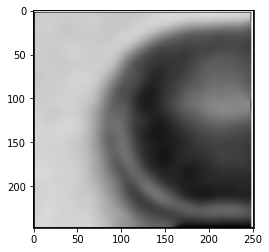

In [69]:
  
im2 = anisodiff(resultImage, 100, 0.15, 0.10)
#im2 = anisodiff(resultImage, 300, .05, 0.10) ##Diffusion time = 100*(0.1)=10 units  ##recheck the value of b

pyp.figure('Image AFTER Perona-Malik anisotropic diffusion')
pyp.imshow(im2, cmap='gray')
pyp.axis('on')


pyp.show() #Display image